# Steam Game Recommendations 

The goal of this notebook is to prototype some dimensionality reduction, classification, and clustering models on a dataset of Steam games, users, and reviews sourced from Kaggle. 

## Dimensionality Reduction

The games dataset does not have a high number of features, but there is a companion table of metadata for each game. The metadata contains a column called tags, which has various identifier tags for each game. Things like Singleplayer, Multiplayer, Co-op, RPG, Shooter, etc. are included in this column. We plan to pivot the unique set of tags in binary feature columns that will be merged to a subset of the dataset with features like game title, average play time, recommendation ratio,etc. Then we will apply Linear Discriminant Analysis to this set, to assess the ability of dimensionality reduction


In [47]:
import pandas as pd
import ast
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

DATA = "../data/steam/"

In [15]:
games = pd.read_csv(DATA + "games.csv", usecols=['app_id', 'title', 'positive_ratio', 'user_reviews'])
games.head()

,app_id,title,positive_ratio,user_reviews
0,13500,Prince of Persia: Warrior Within™,84,2199
1,22364,BRINK: Agents of Change,85,21
2,113020,Monaco: What's Yours Is Mine,92,3722
3,226560,Escape Dead Island,61,873
4,249050,Dungeon of the ENDLESS™,88,8784


In [16]:
# extract mean hours played from reviews
recommendations = pd.read_csv(DATA + 'recommendations.csv', usecols=['app_id', 'hours'])
average_hours_played = (recommendations
                        .groupby('app_id')
                        .mean('hours')
                        .reset_index()
                        )

In [17]:
# merge mean hours played with games, impute missing values as median
games = pd.merge(games, average_hours_played, how='left', on='app_id')
games['hours'] = games['hours'].fillna(games['hours'].median())
games.head()

,app_id,title,positive_ratio,user_reviews,hours
0,13500,Prince of Persia: Warrior Within™,84,2199,18.967912
1,22364,BRINK: Agents of Change,85,21,6.236682
2,113020,Monaco: What's Yours Is Mine,92,3722,20.413294
3,226560,Escape Dead Island,61,873,10.776625
4,249050,Dungeon of the ENDLESS™,88,8784,40.621691


From our key numerical columns of positive_ratio, user_reviews, and mean hours played, we will construct a feature that defines the "success" of the game. To do this will assign a point for each quartile in each of these columns, starting with 0. So for example if a game were in the highest 25% for hours played, number of reviews and positive review ratio, it would score a 9 (3 for each), in the bottom 25% of each would score a 0. In the top 50% of reviews, but bottom 25% of hours played, and in the second quartile for positive ratio, would score a 3.

We will use the success score later to classify our games based on their tags.

In [18]:
def assign_quartile_score(series_to_score):
    """
    Assigns points (0-3) based on the quartile of a numerical series.
    0 points for Q1, 1 for Q2, 2 for Q3, 3 for Q4.
    Handles NaNs by assigning 0 points.
    """
    # Ensure the series is numeric, coercing errors to NaN
    numeric_series = pd.to_numeric(series_to_score, errors='coerce')

    scored_series = pd.qcut(
        numeric_series,
        q=4,
        labels=[0, 1, 2, 3],
        duplicates='drop'
    ).astype(float) 

    scored_series = scored_series.fillna(0)

    return scored_series

score_metrics = ['positive_ratio', 'user_reviews', 'hours']
games['success_score'] = 0.0

# Calculate points for each metric and add them to the total score
for col in score_metrics:
    games[f'{col}_points'] = assign_quartile_score(games[col])
    games['success_score'] += games[f'{col}_points']

Merge in metadata for games, description and tags

In [19]:
metadata = pd.read_json(DATA + "games_metadata.json", lines=True)
# ensure that the tags column is a Python list, so we can use it as such later
metadata['tags'] = metadata['tags'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )

metadata.head()

,app_id,description,tags
0,13500,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre..."
1,22364,,[Action]
2,113020,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
3,226560,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P..."
4,249050,Dungeon of the Endless is a Rogue-Like Dungeon...,"[Roguelike, Strategy, Tower Defense, Pixel Gra..."


In [20]:
# merge tags and description to games
games_metadata = pd.merge(games, metadata, on='app_id', how='left')

In [21]:
def binarize_tags(df: pd.DataFrame, tag_column: str) -> pd.DataFrame:
    """
    Transforms a DataFrame column containing a JSON list of tags into multiple binary columns, one for each unique tag. 
    Use sklearn MultiLabelBinarizer for perfomance
    
    Args:
    df (pd.DataFrame): An input pandas DataFrame that contains tags column
    tag_column (str): The string name of the column containing tags
    
    Returns:
    pd.DataFrame: A new DataFrame object with original columns plus binary column for each unique tag. 
    """
    df_copy = df.copy()
    
    mlb = MultiLabelBinarizer()
    binarized_data = mlb.fit_transform(df_copy[tag_column])

    df_binarized_tags = pd.DataFrame(binarized_data, columns=mlb.classes_, index=df_copy.index)

    df_final = pd.concat([df_copy, df_binarized_tags], axis=1)
    return df_final

# pivot each unique tag into a binary column where 1 if tag present
games_metadata = binarize_tags(games_metadata, 'tags')
games_metadata.columns

Index(['app_id', 'title', 'positive_ratio', 'user_reviews', 'hours',
       'success_score', 'positive_ratio_points', 'user_reviews_points',
       'hours_points', 'description',
       ...
       'Well-Written', 'Werewolves', 'Western', 'Wholesome', 'Word Game',
       'World War I', 'World War II', 'Wrestling', 'Zombies', 'eSports'],
      dtype='object', length=452)

In [22]:
# consider only tags for PCA
exclude_columns = ['app_id',
                   'title',
                   'description',
                   'tags',
                   'positive_ratio',
                   'user_reviews', 
                   'tags', 
                   'success_score',
                   'positive_ratio_points',
                   'user_review_points',
                   'hours_points'
                   ]
pca_features = games_metadata.loc[:, ~games_metadata.columns.isin(exclude_columns)]

# Standardize the features 
scaler = StandardScaler()
pca_features_standardized = scaler.fit_transform(pca_features)


First we run PCA with the maximum number of components, 443. We will plot the explained variance by each principal component and the cumulative explained variance by all principal components, looking for at minimum 80% but hopefully more 

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=443)
games_pca = pca.fit_transform(pca_features_standardized)
games_pca = pd.DataFrame(games_pca)
pca_columns = ['PC' + str(i) for i in range(1, len(games_pca.columns) + 1)]
games_pca.columns = pca_columns
games_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC434,PC435,PC436,PC437,PC438,PC439,PC440,PC441,PC442,PC443
0,3.735801,1.265086,2.842077,0.614051,-1.646951,-1.077142,1.096822,0.190526,-0.705343,4.050975,...,-0.135181,-0.466190,0.792611,0.246433,-0.006247,-0.252255,1.095552,1.835126,-0.138584,-0.827112
1,-2.239288,-1.906882,0.458935,0.269194,-0.142058,-0.501294,0.223758,-0.400933,-0.220301,0.280677,...,-0.072837,-0.064904,0.033169,-0.045894,-0.016603,-0.020348,0.093343,0.100402,0.042672,-0.076909
2,0.437544,3.500451,3.151625,1.149228,-0.702902,1.803340,-1.215951,0.479158,-0.777362,-0.165502,...,-0.914808,0.139477,-0.278862,0.078708,0.116335,0.676594,0.593609,0.303101,-0.005005,0.066598
3,1.338139,1.982501,3.362377,-1.295898,-5.715716,0.796349,1.103081,1.429104,-1.838489,-0.171953,...,0.695493,0.483807,-0.995928,0.855831,0.166023,-0.337965,0.638081,1.995829,-1.483789,0.124196
4,0.111637,4.848265,-0.712946,4.330792,-0.177719,-2.851206,4.291197,-0.781963,1.212417,-4.008059,...,0.917894,0.854933,-0.799525,0.312763,0.147780,-1.826429,-0.206281,0.183897,0.239538,0.278919


In [26]:
pca_variances = pca.explained_variance_ratio_
pca_variances = pd.DataFrame(pca_variances)
pca_variances.columns = ['Explained Variance']
pca_variances.index = pca_columns
print(pca_variances)

       Explained Variance
PC1              0.015481
PC2              0.014727
PC3              0.013054
PC4              0.011930
PC5              0.011462
...                   ...
PC439            0.000761
PC440            0.000753
PC441            0.000749
PC442            0.000742
PC443            0.000738

[443 rows x 1 columns]


In [27]:
games_pca['Cumulative Variance'] = games_pca.sum(axis=1)
games_pca.head()

pca_variances['Cumulative Variance'] = pca_variances['Explained Variance'].cumsum()
pca_variances.head()


,Explained Variance,Cumulative Variance
PC1,0.015481,0.015481
PC2,0.014727,0.030208
PC3,0.013054,0.043261
PC4,0.011930,0.055192
PC5,0.011462,0.066653


In [28]:
import plotly.express as px

fig = px.bar(pca_variances, x=pca_columns, y='Explained Variance', title='Explained Variance by PC',
             labels={'Explained Variance': 'Explained Variance', 'PC': 'PC'},
             color_discrete_sequence=px.colors.qualitative.Pastel1)
fig.show()
fig = px.bar(pca_variances, x=pca_columns, y='Cumulative Variance', title='Cumulative Variance by PC',
             labels={'Cumulative Variance': 'Cumulative Variance', 'PC': 'PC'},
             color_discrete_sequence=px.colors.qualitative.Pastel1)
fig.show()

To retain 90% of the variance, we need 350 features, and to retain 80% of the variance 283 features. 

In [29]:
pca = PCA(n_components=350)
games_pca = pca.fit_transform(pca_features_standardized)
games_pca = pd.DataFrame(games_pca)
pca_columns = ['PC' + str(i) for i in range(1, len(games_pca.columns) + 1)]

In [30]:
loadings = pca.components_
loadings = pd.DataFrame(loadings,
                           columns=pca_features.columns,
                           index=[f'PC{i+1}' for i in range(pca.n_components_)]
                           )


In [31]:
for i in range(1, 10):
    loadings_sorted = loadings.loc['PC' + str(i)].abs().sort_values(ascending=False)
    print(f"Component: {i}" )
    print(loadings_sorted.head(10))
    print("---------------------")

Component: 1
Story Rich          0.221179
Singleplayer        0.185611
Atmospheric         0.181281
Mystery             0.168789
2D                  0.151547
Adventure           0.151365
Exploration         0.150146
Multiple Endings    0.148329
Puzzle              0.146933
Visual Novel        0.144236
Name: PC1, dtype: float64
---------------------
Component: 2
Multiplayer      0.154796
Singleplayer     0.138591
PvP              0.137639
Tactical         0.133458
Building         0.127374
3D               0.125454
Co-op            0.123588
Base Building    0.121261
Sandbox          0.119798
Strategy         0.117809
Name: PC2, dtype: float64
---------------------
Component: 3
Action                 0.225081
Strategy               0.178974
Shooter                0.163481
Turn-Based Strategy    0.156830
Management             0.155667
Arcade                 0.152692
Turn-Based Tactics     0.137691
Economy                0.130944
Resource Management    0.130429
Turn-Based Combat      0.12

We see by inspecting the loadings of some of our components what each explains. For example PC1, has top loadings of Story Rich, Singeplayer, Atmospheric, Mystery, and 2D. This shows some of the tags that are important separators for games that users play.

Overall the model allows us to reduce only by 22% to retain 90% of the variance. This is not a great gain, and other approaches might be considered, like exlcluding very rarely used tags, to reduce dimensionality.

## Classfication

Here we proceed to use our dataset with reduced dimensionality to classify the success_score based on the reduced tags data 



In [34]:
pca_merge = pd.concat(objs=[games_metadata[['title', 'success_score']], games_pca], axis=1)
pca_merge

,title,success_score,0,1,2,3,4,5,6,7,...,340,341,342,343,344,345,346,347,348,349
0,Prince of Persia: Warrior Within™,8.0,3.735801,1.265086,2.842077,0.614051,-1.646951,-1.077142,1.096822,0.190526,...,0.808761,1.062701,0.724319,0.605994,-0.006424,1.057110,0.376684,0.843288,-0.532403,2.403435
1,BRINK: Agents of Change,4.0,-2.239288,-1.906882,0.458935,0.269194,-0.142058,-0.501294,0.223758,-0.400933,...,0.058600,-0.167893,-0.106237,0.020265,0.039864,0.074264,-0.181379,0.106480,-0.060574,0.053492
2,Monaco: What's Yours Is Mine,9.0,0.437544,3.500451,3.151625,1.149228,-0.702902,1.803340,-1.215951,0.479158,...,0.466884,-0.426920,0.444070,0.337871,-0.189942,-0.540227,0.102844,-0.509404,0.146204,-0.170611
3,Escape Dead Island,6.0,1.338139,1.982501,3.362377,-1.295898,-5.715716,0.796349,1.103081,1.429104,...,0.958073,0.516614,-0.724474,0.069025,0.272545,0.867045,0.677833,0.702910,1.553356,1.008720
4,Dungeon of the ENDLESS™,8.0,0.111637,4.848265,-0.712946,4.330792,-0.177719,-2.851206,4.291197,-0.781963,...,0.235913,0.254406,-0.550774,0.247270,0.688419,0.258463,0.277266,0.115288,-0.547077,-1.151853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50867,I Expect You To Die 3: Cog in the Machine,6.0,-2.158890,-2.025058,-0.021740,0.183012,-0.053299,-0.484384,0.110251,-0.316789,...,-0.022431,-0.015630,-0.125484,0.055692,0.153097,0.118898,-0.111879,-0.004173,-0.098431,0.027222
50868,PAYDAY 3,4.0,-2.127715,-1.970675,-0.047831,0.184138,-0.133642,-0.411837,0.113668,-0.300441,...,-0.167900,-0.115459,-0.141340,0.092931,0.130234,0.062414,-0.030713,-0.001380,-0.181672,0.096435
50869,Eternights,6.0,-2.127715,-1.970675,-0.047831,0.184138,-0.133642,-0.411837,0.113668,-0.300441,...,-0.167900,-0.115459,-0.141340,0.092931,0.130234,0.062414,-0.030713,-0.001380,-0.181672,0.096435
50870,Forgive Me Father 2,6.0,2.476680,2.089344,3.871341,-1.161820,-3.334106,-1.605704,-0.079162,0.721176,...,1.677371,0.024937,-1.025946,1.285097,0.259059,0.552900,1.641465,-0.339625,1.621976,0.134319


In [35]:
from sklearn.neighbors import KNeighborsClassifier

games_neighbors = KNeighborsClassifier(n_neighbors=5)
games_neighbors.fit(games_pca, pca_merge['success_score'])
games_neighbors_predictions = games_neighbors.predict(games_pca)

In [38]:
from sklearn.naive_bayes import GaussianNB

games_gnb = GaussianNB()
games_gnb.fit(games_pca, pca_merge['success_score'])
nb_predictions = games_gnb.predict(games_pca)

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def determine_metrics(actual_values, predictions):
    metrics = {}
    metrics['Accuracy'] = accuracy_score(actual_values, predictions)
    metrics['Precision'] = precision_score(actual_values, predictions, average='weighted')
    metrics['Recall'] = recall_score(actual_values, predictions, average='weighted')
    metrics['F1'] = f1_score(actual_values, predictions, average='weighted')
    metrics = pd.DataFrame.from_dict(metrics, orient='index')
    
    return metrics

kneighbors_metrics = determine_metrics(pca_merge['success_score'], games_neighbors_predictions)
kneighbors_confusion = confusion_matrix(pca_merge['success_score'], games_neighbors_predictions)
nb_metrics = determine_metrics(pca_merge['success_score'], nb_predictions)
nb_confusion = confusion_matrix(pca_merge['success_score'], nb_predictions)

In [44]:
kneighbors_metrics

,0
Accuracy,0.419779
Precision,0.437568
Recall,0.419779
F1,0.418340


In [45]:
nb_metrics

,0
Accuracy,0.112459
Precision,0.143282
Recall,0.112459
F1,0.079307


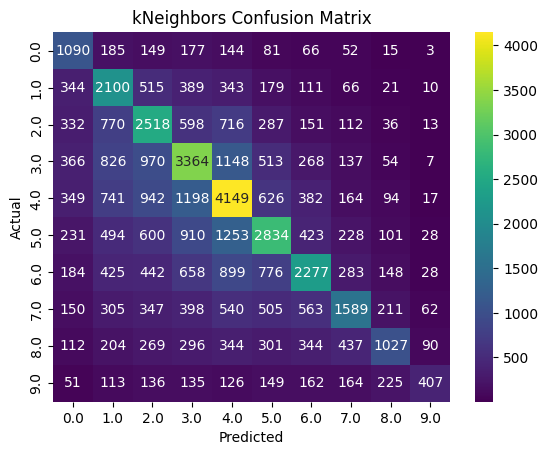

In [49]:
confusion_matrix = pd.crosstab(pca_merge['success_score'], games_neighbors_predictions, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, cmap="viridis", fmt="d")
plt.title("kNeighbors Confusion Matrix")
plt.show()

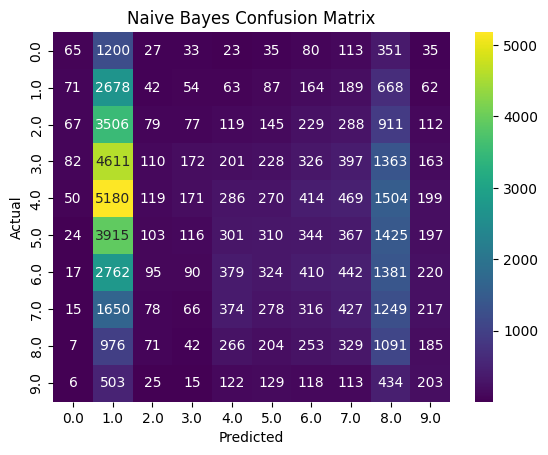

In [51]:
confusion_matrix = pd.crosstab(pca_merge['success_score'], nb_predictions, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, cmap="viridis", fmt="d")
plt.title("Naive Bayes Confusion Matrix")
plt.show()

## NLP Approach

We have lots of text data to try to take advantage of for a natural language processing based approach. Our game title and description are string data we can glean information from and use to determine similarity 

In [16]:
nlp_data = games_metadata[['title', 'description']].copy()
nlp_data['combined_text'] = (
    nlp_data['title'].fillna('') + " " +
    nlp_data['description'].fillna('') + " "
)

In [17]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.metrics.pairwise import linear_kernel

hv = HashingVectorizer(analyzer="word", ngram_range=(1,2), stop_words="english", n_features=2**18, norm='l2', binary=False)
tfidf_matrix_hashed = hv.fit_transform(nlp_data['combined_text'])
cosine_similarities_hashed = linear_kernel(tfidf_matrix_hashed, tfidf_matrix_hashed)

In [18]:
def get_recommendations(title, sim_matrix, df, indices_series, num_recommendations=5):
    """
    Generates game recommendations based on a tag-based similarity matrix.

    Args:
        title (str): The title of the game to get recommendations for.
        sim_matrix (np.array): The pre-calculated tag-based similarity matrix.
        df (pd.DataFrame): The original DataFrame containing game titles.
        indices_series (pd.Series): A Series mapping game titles to their DataFrame indices.
        num_recommendations (int): The number of top recommendations to return.

    Returns:
        pd.DataFrame: A DataFrame of recommended game titles and their similarity scores.
                      Returns None if the title is not found.
    """
    if title not in indices_series:
        print(f"Error: Game '{title}' not found in the dataset.")
        return None

    idx = indices_series[title]
    sim_scores = list(enumerate(sim_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:num_recommendations+1]
    game_indices = [i[0] for i in sim_scores]
    game_similarities = [i[1] for i in sim_scores]

    recommended_games = df.iloc[game_indices][['title']]
    recommended_games['Similarity_Score'] = game_similarities
    return recommended_games

In [ ]:
indices = pd.Series(nlp_data.index, index=nlp_data['title']).drop_duplicates()

In [20]:
get_recommendations("Baldur's Gate 3", cosine_similarities_hashed, nlp_data, indices, 10)

,title,Similarity_Score
19171,Baldur's Gate: Siege of Dragonspear,0.654654
47535,Baldur's Gate: Enhanced Edition,0.654654
15407,Baldur's Gate: Faces of Good and Evil,0.577350
15812,Baldur's Gate II: Enhanced Edition,0.577350
6681,Baldur's Gate: Enhanced Edition Official Sound...,0.522233
9937,Baldur's Gate: Siege of Dragonspear Official S...,0.522233
14335,Baldur's Gate 3 - Digital Deluxe Edition DLC,0.522233
1619,Baldur's Gate II: Enhanced Edition Official So...,0.480384
11257,Baldur's Gate: Dark Alliance,0.480384
48994,Baldur's Gate: Dark Alliance II,0.247436


In [21]:
get_recommendations("Outer Wilds", cosine_similarities_hashed, nlp_data, indices, 10)

,title,Similarity_Score
12140,Outer Wilds - Original Soundtrack,0.654654
48842,Outer Wilds - Echoes of the Eye,0.654654
47724,The Outer Worlds,0.333333
9379,BallisticNG - Outer Reaches,0.258199
14451,Smalland: Survive the Wilds,0.258199
14761,The Outer Worlds Original Soundtrack,0.218218
15836,MudRunner - American Wilds Expansion,0.218218
17322,The Outer Worlds: Murder on Eridanos,0.218218
28984,The Outer Worlds Expansion Pass,0.218218
48664,The Outer Worlds: Peril on Gorgon,0.218218


In [22]:
get_recommendations("Prince of Persia: Warrior Within™", cosine_similarities_hashed, nlp_data, indices, 10)

,title,Similarity_Score
19579,Prince of Persia®,0.394155
19153,Prince of Persia: The Two Thrones™,0.337107
12694,Prince of Persia: The Forgotten Sands™,0.334752
9419,Prince of Persia®: The Sands of Time,0.288196
11200,Dark Parables: The Exiled Prince Collector's E...,0.192538
6958,RATUZ,0.164620
10978,Karateka,0.149654
27669,Sockman,0.146568
7675,The Last Express Gold Edition,0.133540
41961,Tragedy of Prince Rupert,0.128185


This works, but given that for many games, title is the only data given, we are 

In [23]:
non_feature_columns = ['app_id', 
                       'title',
                       'positive_ratio',
                       'user_reviews',
                       'hours',
                       'description',
                       'tags'
                       ]

feature_columns = [col for col in games_metadata.columns if col not in non_feature_columns]
tag_features = games_metadata[feature_columns].copy()
tag_features = tag_features.values

In [24]:
tag_cosine_similarities = linear_kernel(tag_features, tag_features)

: 

In [ ]:
get_recommendations("Prince of Persia: Warrior Within™", tag_cosine_similarities, nlp_data, indices, 10)

NameError: name 'jaccard_similarity_matrix' is not defined